This notebook plots ROIs from minian along with max and min projections to aid in tracking neurons across days and eventually cross-registering.  Much of this will be built into TraceFC and/or NeuroPy modules, but the backbone is here for easy visualiation.

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import os
import xarray as xr

if os.environ['SHELL'] == '/bin/zsh':
    sys.path.append('/Users/nkinsky/Documents/UM/GitHub/TraceFC/')
    sys.path.append('/Users/nkinsky/Documents/UM/GitHub/NeuroPy/')
elif os.environ['SHELL'] in ['/bin/bash', '/bin/sh']:
    sys.path.append('/data/GitHub/TraceFC/')
    sys.path.append('/data/GitHub/NeuroPy/')
%load_ext autoreload
%autoreload 2

from neuropy.plotting.ca_events import plot_pe_traces
from neuropy.io.minianio import MinianIO
from neuropy.core.ca_neurons import CaNeuronReg, CaNeurons, id_and_plot_reference_cells, detect_roi_centroid, PairwiseMap

# Put any user-defined functions for grabbing recording folder locations here
try:
    use_sd = True
    import session_directory as sd
except ModuleNotFoundError:
    use_sd = False
    print('No session_directory module found - enter recording folders by hand below')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Enter sessions you want to register here, either directly by path or by defining a project-specific lambda function to grab each directory

In [2]:
# list either session alias here if using session_directory or full path to recording folders
session_list = ['Habituation2', 'Training', 'Recall1']
animal = 'Jyn'

dir_use = session_list if not use_sd else lambda session: sd.get_session_dir(animal, session)

In [3]:
# assemble data
careg = CaNeuronReg([MinianIO(basedir=dir_use(session)).trim_neurons(keep=['good', 'maybe_interneurons']) 
                     for session in session_list], alias=session_list)

Keeping 38282 good frames found in "good_frames_bool.npy" file
Eliminating timestamps from corrupted video10 in 12_46_16 folder.
Keeping 152933 good frames found in "good_frames_bool.npy" file
Keeping 47329 good frames found in "good_frames_bool.npy" file


First plot and identify reference cells that are active across all sessions

<IPython.core.display.Javascript object>


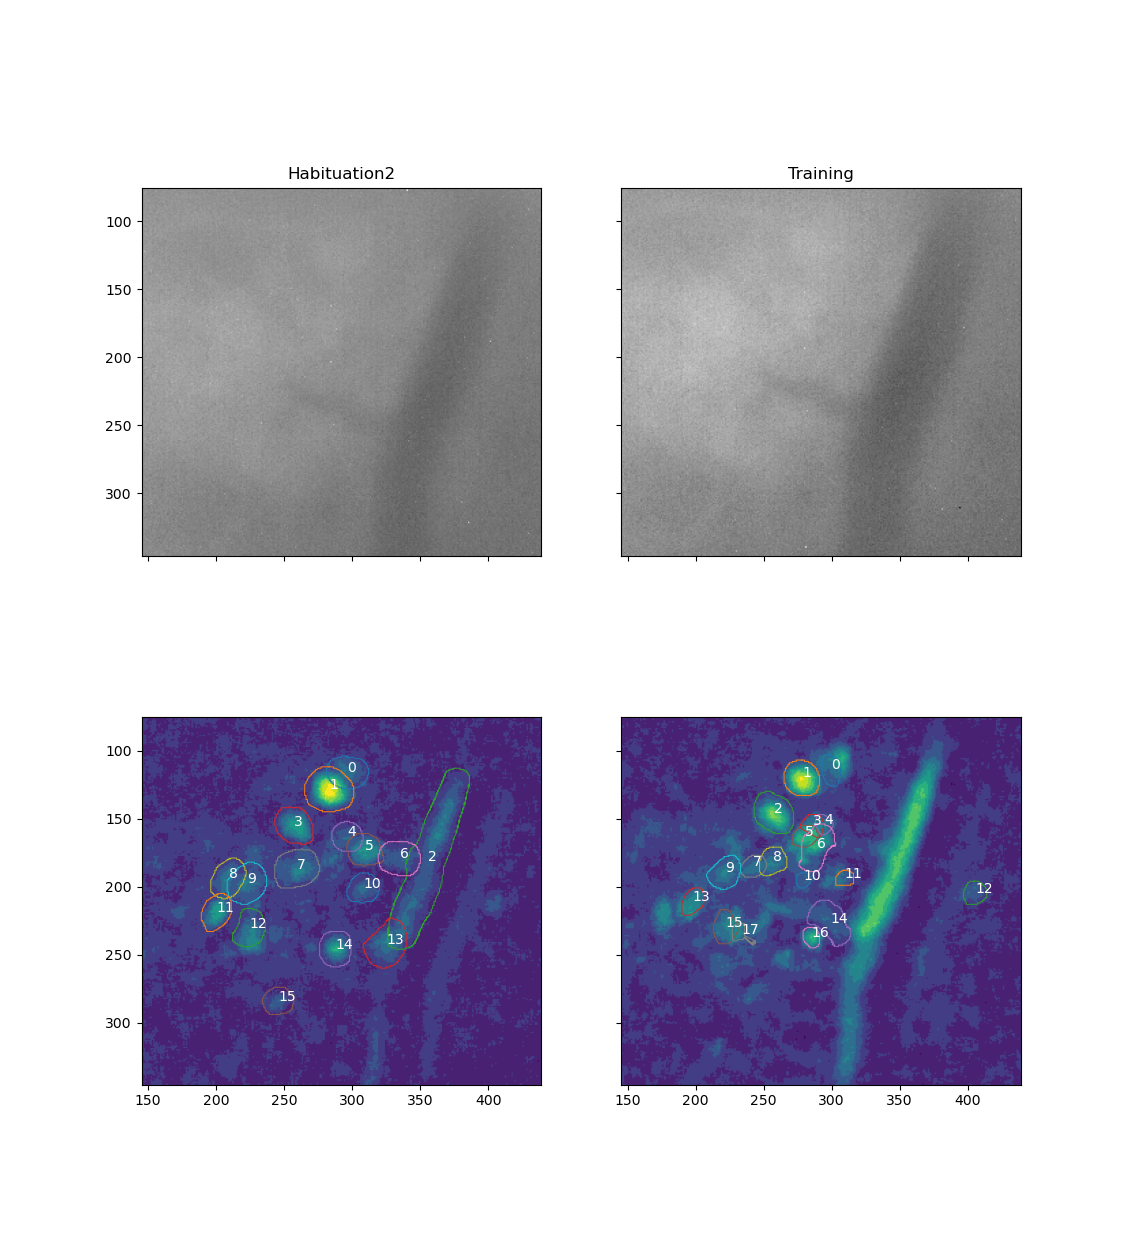

In [5]:
%matplotlib notebook
sesh1, sesh2 = 'Habituation2', 'Training'
careg.plot_rois_across_sessions(sesh_plot=[sesh1, sesh2])

<IPython.core.display.Javascript object>


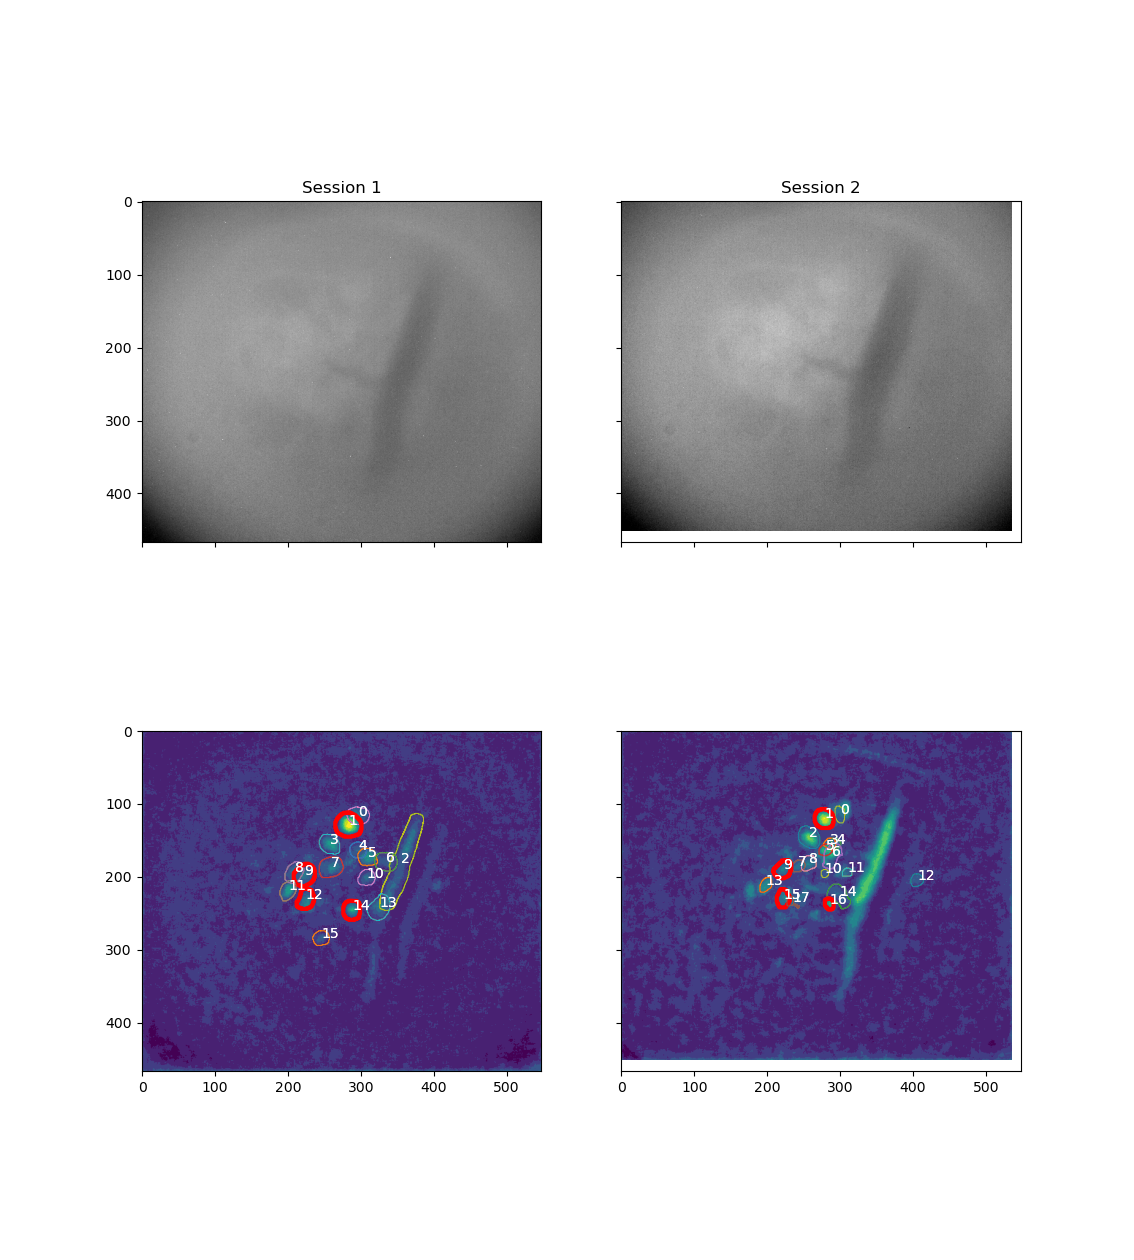


Enter (co-active) reference neurons from session 1 (space between) : 1 9 12 14

Enter (co-active) reference neurons from session 2 (space between) : 1 9 15 16


(<Figure size 1134x1260 with 4 Axes>,
 array([[<AxesSubplot:title={'center':'Session 1'}>,
         <AxesSubplot:title={'center':'Session 2'}>],
        [<AxesSubplot:>, <AxesSubplot:>]], dtype=object))

In [31]:
%matplotlib notebook
id_and_plot_reference_cells(careg.get_session(sesh1), careg.get_session(sesh2))

In [8]:
# Match up neurons here
print('Session 1 neurons:')
print([a for a in range(careg.get_session(sesh1).A.shape[0])])
sesh1_sesh2_map = list(map(int,input("\nEnter session 2 neurons that match session 1 above (silent = -1) : ").
                           strip().split(",")))
map_df = pd.DataFrame({sesh1: np.arange(len(sesh1_sesh2_map)), sesh2: sesh1_sesh2_map})
map_df

Session 1 neurons:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

Enter session 2 neurons that match session 1 above (silent = -1) : -1, 1, -1, 2, 3, 6, -1, 8, -1, 9, 11, 13, 15, 14, 16, -1


,Habituation2,Training
0,0,-1
1,1,1
2,2,-1
3,3,2
4,4,3
5,5,6
6,6,-1
7,7,8
8,8,-1
9,9,9


### Check your work

In [12]:
map_df
coactive_bool = (map_df > -1).all(axis=1)
coactive_map = map_df[coactive_bool]
coactive_map

,Habituation2,Training
1,1,1
3,3,2
4,4,3
7,7,8
9,9,9
10,10,11
11,11,13
12,12,15
14,14,16


# NRK todo:
make plot_overlaid function below and add into CaNeuronReg class to easily plot this elsewhere

<IPython.core.display.Javascript object>


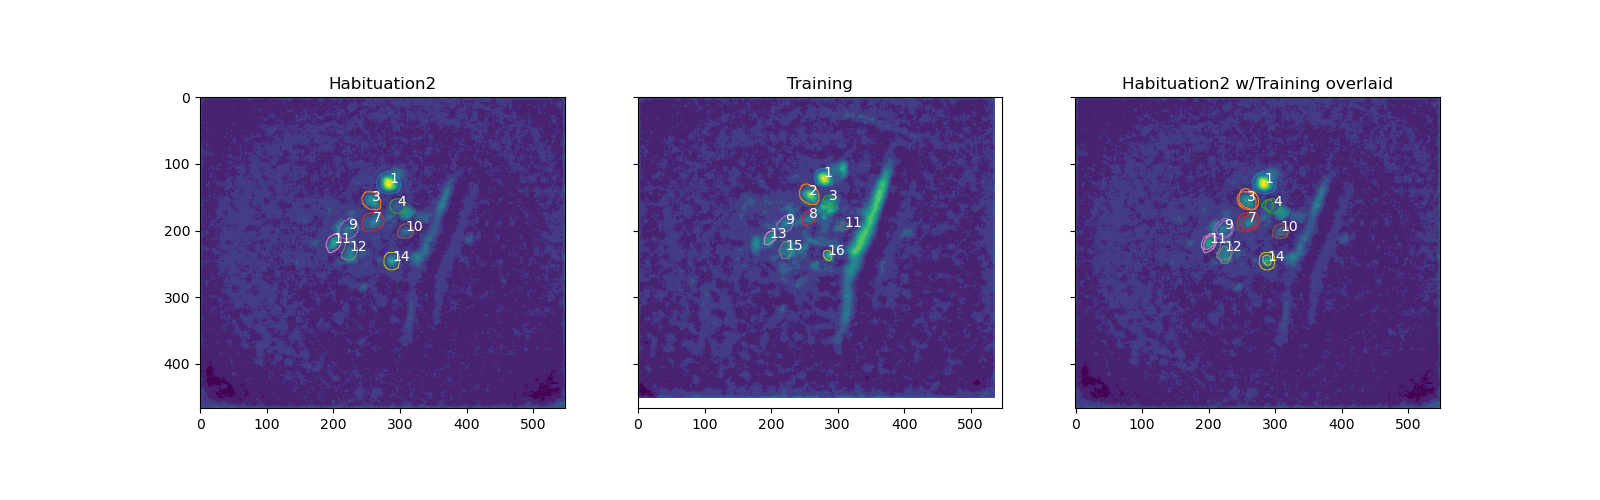

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)

# Plot session 1
careg.get_session(sesh1).plot_rois(neuron_inds=coactive_map[sesh1], label=True, ax=ax[0])

# Plot session 2
careg.get_session(sesh2).plot_rois(neuron_inds=coactive_map[sesh2], label=True, ax=ax[1])
[a.set_title(sesh) for a, sesh in zip(ax[:2], (sesh1, sesh2))];

# Plot them overlaid
careg.plot_reg_neurons_overlaid(sesh1, sesh2, map_df, ax=ax[2], color=None)

## Adjust any wrongly registered cells by hand here

In [11]:
map_df.iloc[5][1] = -1
map_df.iloc[13][1] = -1
map_df

,Habituation2,Training
0,0,-1
1,1,1
2,2,-1
3,3,2
4,4,3
5,5,-1
6,6,-1
7,7,8
8,8,-1
9,9,9


### Now save the map between sessions and check to make sure it saved properly

In [20]:
pw_map = PairwiseMap(careg, map_df, animal, sesh1, sesh2)

savename = careg.get_session(sesh1).basedir / f'map_{sesh1}_{sesh2}.pwmap.npy'
np.save(savename, pw_map, allow_pickle=True)

In [21]:
map_df

,Habituation2,Training
0,0,-1
1,1,1
2,2,-1
3,3,2
4,4,3
5,5,-1
6,6,-1
7,7,8
8,8,-1
9,9,9


In [22]:
pw_map_check = np.load(savename, allow_pickle=True).item()
pw_map_check.map

,Habituation2,Training
0,0,-1
1,1,1
2,2,-1
3,3,2
4,4,3
5,5,-1
6,6,-1
7,7,8
8,8,-1
9,9,9


Finally save this notebook to the sesh1 directory for documentation purposes.

In [24]:
nb_copy_savename

PosixPath('/data2/Trace_FC/Recording_Rats/Jyn/2022_06_16_habituation2/Jyn_Habituation2_Training_manual_cell_reg.ipynb')

In [26]:
import ipynbname
import shutil
nb_fname = ipynbname.name()
nb_path = ipynbname.path()

nb_copy_savename = careg.get_session(sesh1).basedir / f'{animal}_{sesh1}_{sesh2}_manual_cell_reg.ipynb'
shutil.copy(str(nb_path), str(nb_copy_savename))

'/data2/Trace_FC/Recording_Rats/Jyn/2022_06_16_habituation2/Jyn_Habituation2_Training_manual_cell_reg.ipynb'